<a href="https://colab.research.google.com/github/kol-di/ml-for-model-development-miem/blob/main/MLForModelDevelopment_HW3_Kolobaev_Dmitry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Task 1: maximum likelihood fit (3 points)


Let's generate a Gaussian mixture dataset and then fit its parameters with maximum likelihood.

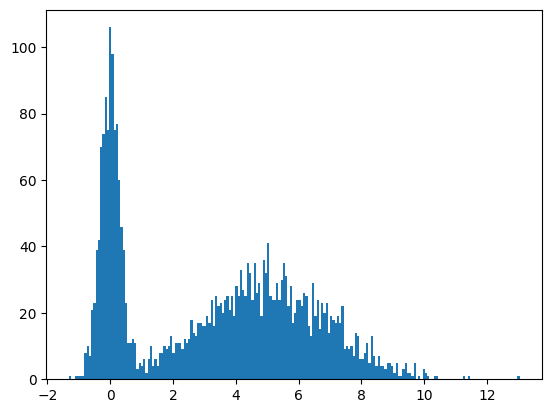

In [88]:
X1 = np.random.normal(size=1000, scale=0.3).astype('float32')
X2 = np.random.normal(size=2000, loc=5., scale=2.).astype('float32')

X = np.concatenate([X1, X2])
np.random.shuffle(X)

plt.hist(X, bins=200);

X = torch.tensor(X, requires_grad=False, dtype='float32')

**Task**:
 - fill the gaps below to perform the max. likelihood fit with the pdf:
$$\text{PDF}(x|\mu_1, \sigma^2_1, \mu_2, \sigma^2_2, \alpha)
= \alpha\cdot\mathscr{N}(x|\mu_1, \sigma_1^2) + (1 - \alpha)\cdot\mathscr{N}(x|\mu_2, \sigma_2^2)$$
 - what the fitted values of $\mu_1, \sigma^2_1, \mu_2, \sigma^2_2$ and $\alpha$ should be? does your fit converge to them?

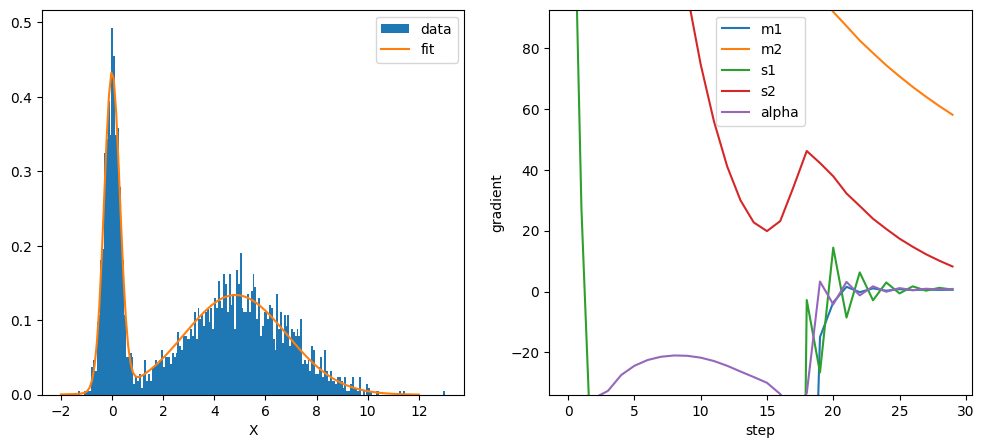

In [102]:
from IPython.display import clear_output
import math


# Defining Gaussian PDF using torch functions
def gaussian(x, mu, sigma):
  # <YOUR CODE> # use torch.exp for the exponent, don't forget the normalization
    pdf = 1 / torch.sqrt( 2 * torch.tensor(math.pi) * torch.square(sigma) ) * \
        torch.exp( -torch.square(x-mu) / (2*torch.square(sigma)) )
    return pdf


# Arbitrary mixture PDF
def mixture(x, f1, f2, alpha):
    return alpha * f1(x) + (1. - alpha) * f2(x)


# Parameters that we'd like to infer (with an initial guess)
m1    = torch.Tensor([1.0])
m2    = torch.Tensor([4.0])
s1    = torch.Tensor([1.0])
s2    = torch.Tensor([1.0])
alpha = torch.Tensor([0.5])

variables = [m1, m2, s1, s2, alpha]
for var in variables:
    var.requires_grad=True

# At each gradient update we'll apply this function to
# ensure valid parameter values
def apply_constraints():
  # <YOUR CODE> # ensure the sigmas are positive (greater or equal to some small
              # positive number, e.g. 1e-5) and alpha is in (0, 1) interval
    with torch.no_grad():
        s1.clamp_(min=1e-5)
        s2.clamp_(min=1e-5)
        alpha.clamp_(min=0, max=1)

# Defining the overall PDF
def model_pdf(x):
  return mixture(x,
                 lambda t: gaussian(t, m1, s1),
                 lambda t: gaussian(t, m2, s2),
                 alpha)


# Log likelihood
def loglike(x):
  # <YOUR CODE>
    likelihood = model_pdf(x)
    return torch.sum(torch.log(likelihood))


learning_rate = 0.0001
grad_history = [] # to keep track of gradient values at different steps


for i in range(30):
    for var in variables:
        if var.grad is not None:
            var.grad.zero_()

    # Forward pass:
    l = loglike(X)

    # Backprop
    l.backward()

    # Gradient ascent step
    with torch.no_grad():
        for var in variables:
            var += var.grad * learning_rate

    apply_constraints()

    grad_history.append([var.grad.item() for var in variables])

    ############################
    # Do some plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(X.detach().numpy(), bins=200, density=True, label='data')
    x_grid = torch.linspace(-2, 12, 150)
    plt.plot(x_grid, model_pdf(x_grid).detach().numpy(), label='fit')
    plt.legend()
    plt.xlabel('X')

    plt.subplot(1, 2, 2)
    lines = plt.plot(np.array(grad_history))
    low = min(grad_history[-1])
    high = max(grad_history[-1])
    plt.ylim(low  - (high - low) * 0.6,
            high + (high - low) * 0.6)
    plt.legend(lines, ['m1', 'm2', 's1', 's2', 'alpha'])
    plt.xlabel('step')
    plt.ylabel('gradient')
    plt.show()
    clear_output(wait=True);

In [107]:
s2

tensor([2.0039], requires_grad=True)

Так как MLE является состоятельной оценкой, мы ожидаем, наши параметры будут сходиться к своим реальным значениям. То есть оценки для $\mu_1, \sigma^2_1, \mu_2, \sigma^2_2$ должны сходится по распределению к тем, что мы задали для наших гауссиан (0, 0.3, 5, 2).

$\alpha$ также должна сойтись к своему реальному значению. Для GMM это вероятность, что наблюдение принадлежит той или иной гауссиане. Суммарное количество наблюдений 3000; если $\alpha$ - вероятность, что наблюдение принадлежит первой гауссиане, то оно должно сходиться к $\frac{1000}{3000} = 1/3$

Полученные нами оценки действительно близки к этим значениям. Маленькие отклонения объясняются тем, что наши эмпирические данные не совсем точно отражают заданные распределения, а также тем, что градиентный спуск не может дать настолько же точные результаты, как аналитическое решение задачи минимазации функции правдоподобия.

# Task 2: classifying clothes (3 points)

In [4]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

[['Trouser' 'Pullover' 'Bag' 'Coat' 'Ankle boot' 'Trouser' 'Shirt'
  'Ankle boot']
 ['Sneaker' 'Trouser' 'Sneaker' 'Ankle boot' 'Sneaker' 'Ankle boot'
  'Sandal' 'Sandal']
 ['T-shirt/top' 'Shirt' 'T-shirt/top' 'Trouser' 'Bag' 'Trouser' 'Bag'
  'Sandal']
 ['T-shirt/top' 'Sneaker' 'Sandal' 'Pullover' 'T-shirt/top' 'Shirt'
  'Pullover' 'Trouser']
 ['Coat' 'T-shirt/top' 'Trouser' 'T-shirt/top' 'Sneaker' 'Ankle boot'
  'Shirt' 'Pullover']
 ['Ankle boot' 'Sandal' 'T-shirt/top' 'Trouser' 'Bag' 'Ankle boot'
  'Sneaker' 'Sandal']
 ['Ankle boot' 'Ankle boot' 'T-shirt/top' 'T-shirt/top' 'Ankle boot'
  'Ankle boot' 'Trouser' 'Pullover']
 ['Sandal' 'Bag' 'Dress' 'Coat' 'Pullover' 'Sneaker' 'Shirt'
  'T-shirt/top']]


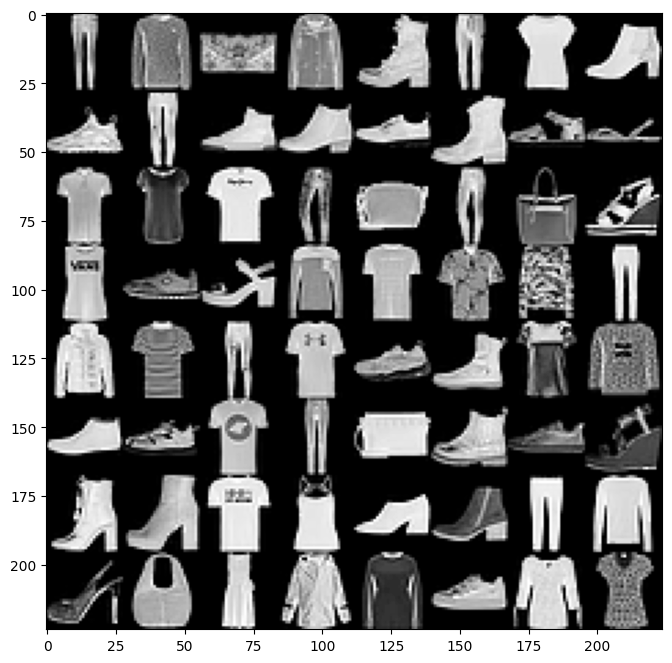

In [5]:
# Array for decoding the categories
label_names = np.array(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle boot'])

# Get a single data batch of 64 images
sample_images, sample_labels = next(iter(trainloader))

# Plot the images in a 8x8 grid
plt.figure(figsize=(8, 8))
plt.imshow(
    sample_images.numpy().reshape(8, 8, 28, 28).transpose((0, 2, 1, 3)).reshape(224, 224),
    cmap='gray'
)
# Print corresponding labels
print(label_names[sample_labels.numpy().reshape(8, 8)])

**Task**:

Train a model which is an average of two models with different numbers of layers on the Fashion MNIST dataset, e.g.:

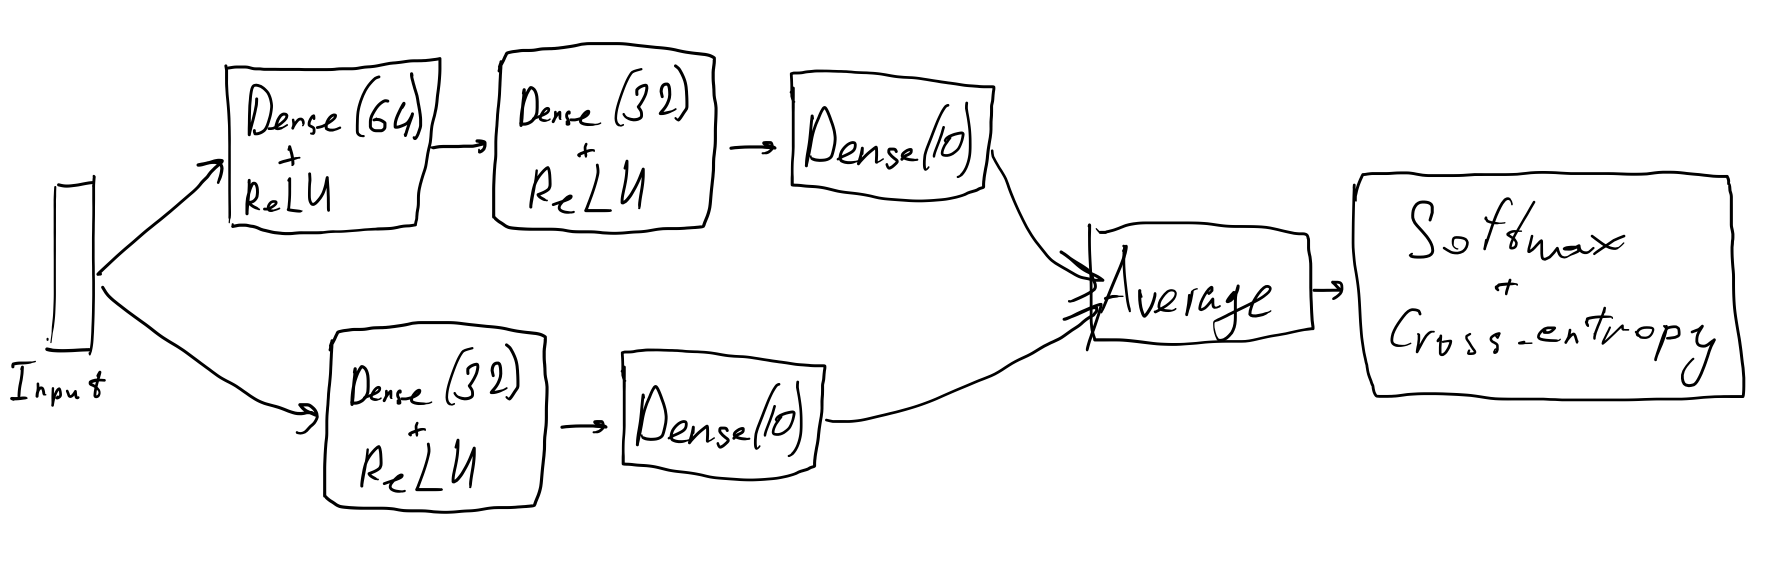

In [6]:
import torch.nn as nn


class AverageLayer(nn.Module):
    def __init__(self):
        super(AverageLayer, self).__init__()

    def forward(self, x):
        return torch.mean(x, dim=0)


class FCNetwork(nn.Module):
    def __init__(self, input_dim):
        super(FCNetwork, self).__init__()
        self.base1 = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
        self.base2 = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
        self.avg = AverageLayer()

    def forward(self, x):
        base1_lat = self.base1(x)
        base2_lat = self.base2(x)
        avg_lat = self.avg(
            torch.stack([base1_lat, base2_lat], dim=0)
        )
        return avg_lat


In [13]:
DEVICE = 'cuda'

model = FCNetwork(28*28)
model.to(DEVICE)

n_epochs=20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.5)

for epoch in range(n_epochs):
    loss_vals = []
    for X, y in trainloader:
        X = X.flatten(1, -1).to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()
        preds = model(X)
        # preds = model.train()(X)
        loss = criterion(preds, y)

        loss.backward()
        loss_vals.append(loss.item())
        optimizer.step()

    print('epoch: ', epoch+1,' mean loss: ', np.mean(loss_vals))

epoch:  1  mean loss:  0.5422268888271694
epoch:  2  mean loss:  0.40544631292443795
epoch:  3  mean loss:  0.36947002870314666
epoch:  4  mean loss:  0.3462589326809083
epoch:  5  mean loss:  0.32678829537811815
epoch:  6  mean loss:  0.3118162538880097
epoch:  7  mean loss:  0.2995629459460661
epoch:  8  mean loss:  0.28729624397306047
epoch:  9  mean loss:  0.2772015560029158
epoch:  10  mean loss:  0.26853546087961716
epoch:  11  mean loss:  0.2606772497685543
epoch:  12  mean loss:  0.25290838305725216
epoch:  13  mean loss:  0.24591909875588885
epoch:  14  mean loss:  0.2400113403050503
epoch:  15  mean loss:  0.23393690694115563
epoch:  16  mean loss:  0.22707495423776508
epoch:  17  mean loss:  0.2215762607959796
epoch:  18  mean loss:  0.2153571388686199
epoch:  19  mean loss:  0.21172330360899347
epoch:  20  mean loss:  0.2084235467318533


In [51]:
model.eval()

preds = []
y_true = []
for X_test, y_test in testloader:
    X_test = X_test.flatten(1, -1).to(DEVICE)
    y_test = y_test.to(DEVICE).tolist()

    batch_preds = torch.argmax(model(X_test), dim=1).tolist()
    preds.extend(batch_preds)

    y_true.extend(y_test)

Precision (weighted): 0.8806788850357223
Recall (weighted): 0.8785
F1 (weighted): 0.8785


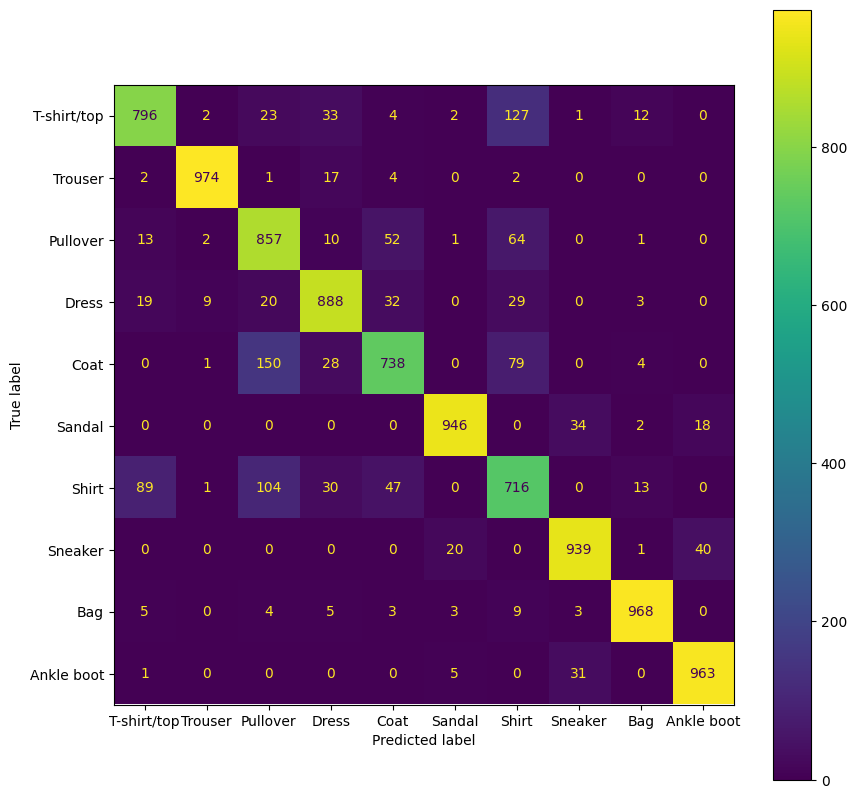

In [69]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

precision, recall, f1, _ = precision_recall_fscore_support(y_true, preds, average='weighted')


cm = confusion_matrix(y_true, preds, labels=np.arange(0, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)

print(f'Precision (weighted): {precision}')
print(f'Recall (weighted): {recall}')
print(f'F1 (weighted): {recall}')